In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

# Setup

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*9,3),np.float32)

# Transpose to (6,9,2), flatten to reshpae(-1,2) and convert to (56,2)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3D points in the real world
imgpoints = [] # points in the 2D image

In [3]:
images = glob.glob('images/*.jpg')
print(images)
path = "storages/"
if not os.path.exists(path):
  os.makedirs(path)

['images\\img1.jpg', 'images\\img10.jpg', 'images\\img11.jpg', 'images\\img12.jpg', 'images\\img13.jpg', 'images\\img14.jpg', 'images\\img15.jpg', 'images\\img16.jpg', 'images\\img2.jpg', 'images\\img3.jpg', 'images\\img4.jpg', 'images\\img5.jpg', 'images\\img6.jpg', 'images\\img7.jpg', 'images\\img8.jpg', 'images\\img9.jpg']


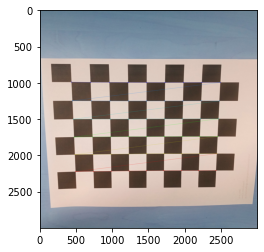

In [4]:
PATTERN_SIZE = (9, 6)
for fname in images:
  img = cv2.imread(fname)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # Find the chess board corners
  ret, corners = cv2.findChessboardCorners(gray, PATTERN_SIZE,None)

  # If found, add object points, image points (after refining them)
  if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, PATTERN_SIZE, corners2,ret)
    plt.imshow(img)
    cv2.imwrite(os.path.join(path , fname[7:-4]+'_corner.jpg'), img)
    cv2.waitKey(100)

cv2.destroyAllWindows()

# Calibration

The function cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [6]:
print("Error in projection : \n", ret)
print("\nCamera matrix : \n", mtx)
print("\nDistortion coefficients : \n", dist)
print("\nRotation vector : \n", rvecs)
print("\nTranslation vector : \n", tvecs)

Error in projection : 
 1.1498073500260286

Camera matrix : 
 [[3.02635452e+03 0.00000000e+00 1.49630878e+03]
 [0.00000000e+00 3.02123608e+03 1.49152639e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients : 
 [[ 2.69810204e-03  1.07229744e+00 -1.66062997e-06 -3.34687985e-03
  -4.43294091e+00]]

Rotation vector : 
 (array([[-0.01232026],
       [-0.01513281],
       [ 0.00993549]]), array([[-0.47312819],
       [-0.51722804],
       [ 0.56413862]]), array([[-0.42993906],
       [ 0.18809032],
       [-1.50601693]]), array([[-0.42889218],
       [-0.24054842],
       [ 1.1809921 ]]), array([[-0.83539349],
       [-0.12892942],
       [-0.56959557]]), array([[ 0.0538158 ],
       [-0.17312429],
       [ 3.12208061]]), array([[-0.76023637],
       [-0.06435059],
       [ 1.51630145]]), array([[-0.80371695],
       [-0.15902534],
       [ 1.09388806]]), array([[-0.09514679],
       [ 0.05283544],
       [ 0.02313387]]), array([[-0.31191271],
       [ 0.08377028],


# Undistortion

In [7]:
# Take an image
img = cv2.imread('images/img4.jpg')
h,w = img.shape[:2]
print(h,w)
newcameraMtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

3000 3000


In [8]:
print(newcameraMtx)
print(roi)

[[2.87071436e+03 0.00000000e+00 1.47373292e+03]
 [0.00000000e+00 2.85453418e+03 1.48219264e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(62, 73, 2838, 2834)


**Using cv2.undistort()**

In [9]:
# Call the function and use ROI obtained above to crop the result

# undistort
dst = cv2.undistort(img,mtx,dist,None,newcameraMtx)

#crop the image
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]
if not os.path.exists('results'):
  os.makedirs('results')
cv2.imwrite('results/calibRes.jpg',dst) #save the result

True

**Using remapping**

In [10]:
img = cv2.imread('images/img4.jpg')
h,w = img.shape[:2]
newcameraMtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [11]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameraMtx, (w,h), 5)
dst_remap = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

#crop the image
x_remap, y_remap, w_remap, h_remap = roi
dst_remap = dst_remap[y_remap:y_remap+h_remap, x_remap:x_remap+w_remap]
cv2.imwrite('results/calibRemap.jpg',dst_remap)

True

Save the camera matrix and distortion coefficients for future use.

In [12]:
np.savez('calib.npz',ret=ret,mtx=mtx,dist=dist,rvecs=rvecs,tvecs=tvecs)

# Re-projection Error

In [13]:
mean_error = 0
for i in range(len(objpoints)):
  imgpoints2,_ = cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist)
  error = cv2.norm(imgpoints[i],imgpoints2,cv2.NORM_L2)/len(imgpoints2)
  mean_error += error
print("Total error : {0}".format(mean_error/len(objpoints)))

Total error : 0.15527103423877575


ss

In [14]:
calib_data = np.load('calib.npz')
cmx = calib_data['mtx']
dist = calib_data['dist']
print("matrice de caméra: \n",cmx)
print("\n")
print("coefficients de distorsion: \n",dist)

matrice de caméra: 
 [[3.02635452e+03 0.00000000e+00 1.49630878e+03]
 [0.00000000e+00 3.02123608e+03 1.49152639e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


coefficients de distorsion: 
 [[ 2.69810204e-03  1.07229744e+00 -1.66062997e-06 -3.34687985e-03
  -4.43294091e+00]]


In [18]:
from PIL import Image

im = Image.open('images/img2.jpg')
image_size = im.size
print(image_size)

(3000, 3000)


In [24]:
fov_x, fov_y, focal_len, principal, aspect = cv2.calibrationMatrixValues(cmx, image_size, 6.4,4.8)
print(fov_x, fov_y, focal_len, principal, aspect)

52.73019220410419 52.80717890075659 6.456222984643396 (3.192125398661181, 2.386442227794785) 0.9983087085211448
